In [1]:
# Importing the required libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm

In [2]:
# Check for cuda availability
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [3]:
# Defining our Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.01)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv6 = nn.Conv2d(32, 10, 3, padding=1)
        # self.conv7 = nn.Conv2d(128, 10, 3, padding=1)
        self.gap = nn.AvgPool2d(7)
        self.batch1 = nn.BatchNorm2d(32)
        self.batch2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.drop1(self.pool1(self.batch1(F.relu(self.conv2(F.relu(self.conv1(x)))))))
        x = self.drop1(self.pool2(self.batch1(F.relu(self.conv4(F.relu(self.conv3(x)))))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [4]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 32, 28, 28]           9,248
       BatchNorm2d-3           [-1, 32, 28, 28]              64
         MaxPool2d-4           [-1, 32, 14, 14]               0
           Dropout-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         MaxPool2d-9             [-1, 32, 7, 7]               0
          Dropout-10             [-1, 32, 7, 7]               0
           Conv2d-11             [-1, 32, 7, 7]           9,248
           Conv2d-12             [-1, 10, 7, 7]           2,890
        AvgPool2d-13             [-1, 10, 1, 1]               0
Total params: 40,330
Trainable params: 

<ipython-input-3-e381f9529b4d>:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [5]:
# Loading & Transforming our data

torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


tensor(-0.4242)
tensor(2.8215)
tensor(0.0056)
tensor(1.0065)
4


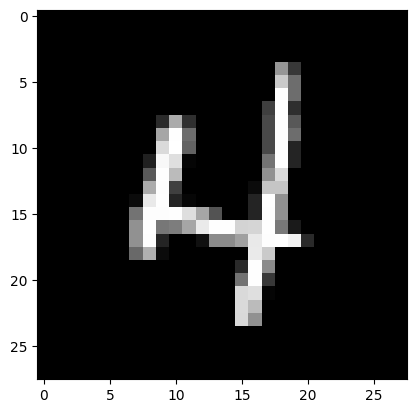

In [6]:
# Check randomly some input images
classes = range(10)
# sanity check for training data
imgs, lbls = next(iter(train_loader))
imgs[7].data.shape
print(imgs.data.min())
print(imgs.data.max())
print(imgs.data.mean())
print(imgs.data.std())
print(classes[lbls[0]])
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

In [7]:
## Defining our train & test functions

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        correct +=GetCorrectPredCount(output, target)
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
# Running the model & checking for accuracy
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-3-e381f9529b4d>:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.10935182124376297 batch_id=468 Accuracy=84.94: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]



Test set: Average loss: 0.1431, Accuracy: 9586/10000 (96%)



loss=0.058287668973207474 batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]



Test set: Average loss: 0.1269, Accuracy: 9619/10000 (96%)



loss=0.13561975955963135 batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:19<00:00, 24.19it/s]



Test set: Average loss: 0.1725, Accuracy: 9522/10000 (95%)



loss=0.04299473762512207 batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:19<00:00, 23.96it/s]



Test set: Average loss: 0.0906, Accuracy: 9723/10000 (97%)



loss=0.04937255382537842 batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]



Test set: Average loss: 0.0796, Accuracy: 9754/10000 (98%)



loss=0.06002213433384895 batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]



Test set: Average loss: 0.1377, Accuracy: 9575/10000 (96%)



loss=0.0034633148461580276 batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:19<00:00, 24.43it/s]



Test set: Average loss: 0.1102, Accuracy: 9672/10000 (97%)



loss=0.0022348808124661446 batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:19<00:00, 23.60it/s]



Test set: Average loss: 0.0803, Accuracy: 9743/10000 (97%)



loss=0.0026045215781778097 batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:19<00:00, 23.46it/s]



Test set: Average loss: 0.2238, Accuracy: 9309/10000 (93%)



loss=0.023166202008724213 batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:19<00:00, 24.52it/s]



Test set: Average loss: 0.0843, Accuracy: 9755/10000 (98%)



loss=0.013414308428764343 batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]



Test set: Average loss: 0.0757, Accuracy: 9756/10000 (98%)



loss=0.0061319018714129925 batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:19<00:00, 24.14it/s]



Test set: Average loss: 0.0927, Accuracy: 9704/10000 (97%)



loss=0.021582558751106262 batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]



Test set: Average loss: 0.1551, Accuracy: 9523/10000 (95%)



loss=0.0006286078714765608 batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]



Test set: Average loss: 0.0641, Accuracy: 9811/10000 (98%)



loss=0.0018291581654921174 batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:18<00:00, 24.73it/s]



Test set: Average loss: 0.0513, Accuracy: 9848/10000 (98%)



loss=0.0101275984197855 batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:20<00:00, 23.26it/s]



Test set: Average loss: 0.0723, Accuracy: 9765/10000 (98%)



loss=0.0032821595668792725 batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]



Test set: Average loss: 0.0636, Accuracy: 9814/10000 (98%)



loss=0.02208680659532547 batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:19<00:00, 23.45it/s]



Test set: Average loss: 0.0554, Accuracy: 9831/10000 (98%)



loss=0.023568401113152504 batch_id=468 Accuracy=99.90: 100%|██████████| 469/469 [00:19<00:00, 23.80it/s]



Test set: Average loss: 0.0490, Accuracy: 9847/10000 (98%)

